# ADTA 5900: CNN on CIFAR-10: Final Project

## Set Path for Data Folder

In [226]:
 # Put file path as a string here

CIFAR_DIR = 'CIFAR_10_DATA/'

## Load Data

In [227]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        cifar_dict = pickle.load(fo, encoding='bytes')
    return cifar_dict

In [228]:
dirs = ['batches.meta','data_batch_1','data_batch_2','data_batch_3','data_batch_4','data_batch_5','test_batch']

all_data = [0,1,2,3,4,5,6]

for i,direc in zip(all_data,dirs):
    all_data[i] = unpickle(CIFAR_DIR+direc)

In [229]:
batch_meta = all_data[0]
data_batch1 = all_data[1]
data_batch2 = all_data[2]
data_batch3 = all_data[3]
data_batch4 = all_data[4]
data_batch5 = all_data[5]
test_batch = all_data[6]

In [230]:
batch_meta

{b'num_cases_per_batch': 10000,
 b'label_names': [b'airplane',
  b'automobile',
  b'bird',
  b'cat',
  b'deer',
  b'dog',
  b'frog',
  b'horse',
  b'ship',
  b'truck'],
 b'num_vis': 3072}

In [231]:
data_batch1.keys()

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])

## Display several examples of single images using matplotlib 

In [232]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

In [233]:
X = data_batch1[b"data"] 

In [234]:
X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("uint8")

In [235]:
X[0].max()

255

In [236]:
(X[0]/255).max()

1.0

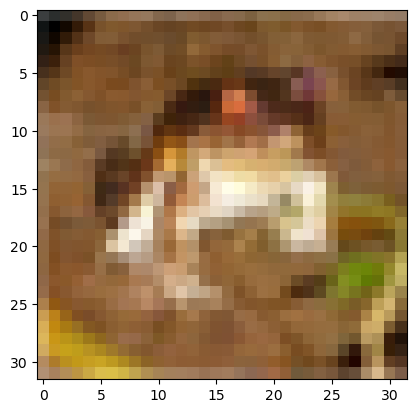

In [237]:
plt.imshow(X[0])

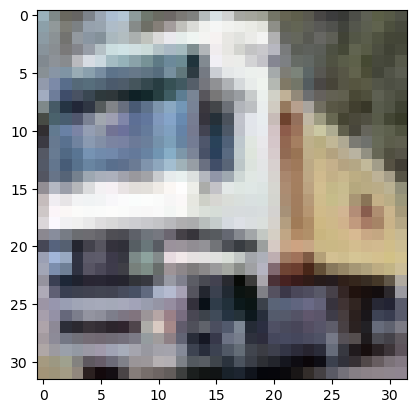

In [238]:
plt.imshow(X[1])

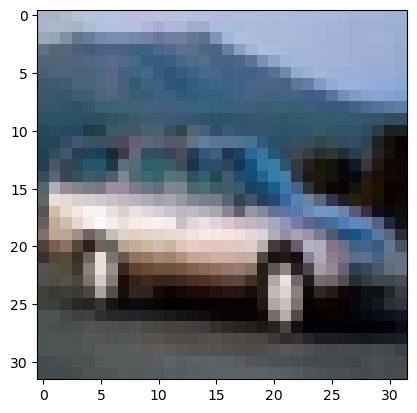

In [239]:
plt.imshow(X[4])

## Supporting Functions to Rearrange Data

### Encode Labels into One-Hot Format

In [240]:
def one_hot_encode(vec, vals=10):
    '''
    For use to one-hot encode the 10- possible labels
    '''
    n = len(vec)
    out = np.zeros((n, vals))
    out[range(n), vec] = 1
    return out

## Set Up Image Data: Make it Ready to be Fed into 1st Conv Layer

In [241]:
class CifarHelper():
    
    def __init__(self):
        self.i = 0
        
        self.all_train_batches = [data_batch1,data_batch2,data_batch3,data_batch4,data_batch5]
        self.test_batch = [test_batch]
        
        self.training_images = None
        self.training_labels = None
        
        self.test_images = None
        self.test_labels = None
    
    def set_up_images(self):
        print("Setting Up Training Images and Labels")
        
        self.training_images = np.vstack([d[b"data"] for d in self.all_train_batches])
        train_len = len(self.training_images)
        
        self.training_images = self.training_images.reshape(train_len,3,32,32).transpose(0,2,3,1)/255
        self.training_labels = one_hot_encode(np.hstack([d[b"labels"] for d in self.all_train_batches]), 10)
        
        print("Setting Up Test Images and Labels")
        
        self.test_images = np.vstack([d[b"data"] for d in self.test_batch])
        test_len = len(self.test_images)
        
        self.test_images = self.test_images.reshape(test_len,3,32,32).transpose(0,2,3,1)/255
        self.test_labels = one_hot_encode(np.hstack([d[b"labels"] for d in self.test_batch]), 10)

        
    def next_batch(self, batch_size):
        x = self.training_images[self.i:self.i+batch_size]
        y = self.training_labels[self.i:self.i+batch_size]
        self.i = (self.i + batch_size) % len(self.training_images)
        return x, y

## Set up image data: Calling CifarHelper.set_up_images()

In [242]:
# Before Your tf.Session run these two lines
ch = CifarHelper()
ch.set_up_images()

# During your session to grab the next batch use this line
# (Just like we did for mnist.train.next_batch)
# batch = ch.next_batch(100)

Setting Up Training Images and Labels
Setting Up Test Images and Labels


## Define Supporting Functions to Build, Train, and Test CNN Model

In [243]:
import tensorflow as tf
import numpy as np
import pickle

In [244]:
def init_weights(shape): 
    init_random_dist = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(init_random_dist)
def init_bias(shape): 
    init_bias_vals = tf.constant(0.1, shape=shape)
    return tf.Variable(init_bias_vals)
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
def max_pool_2by2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
def convolutional_layer(input_x, shape):
    W = init_weights(shape)
    b = init_bias([shape[3]])
    return tf.nn.relu(conv2d(input_x, W) + b)
def normal_full_layer(input_layer, size):
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size, size])
    b = init_bias([size])
    return tf.matmul(input_layer, W) + b

# PHASE I: Build Convolutional Neural Network

## Create Placeholders for Inputs and Labels: x and y_true

In [245]:
# Placeholders
x = tf.placeholder(tf.float32, shape=[None, 32, 32, 3])
y_true = tf.placeholder(tf.float32, [None, 10])
hold_prob = tf.placeholder(tf.float32)
training = tf.placeholder(tf.bool)

## Reshape the Input Placeholder x: NOT NEED TO RESHAPE DATA HERE

In [246]:
# DO NOTHING -- DON'T NEED TO RESHAPE - DATA IS ALREADY IN GOOD SHAPE TO BE FED INTO 1ST CONVOLUTION LAYER

## Create 1st Convolution Layer and so on .............

In [247]:
convo_1 = convolutional_layer(x, shape=[4, 4, 3, 32])
convo_1_pooling = max_pool_2by2(convo_1)

convo_2 = convolutional_layer(convo_1_pooling, shape=[4, 4, 32, 64])
convo_2_pooling = max_pool_2by2(convo_2)

convo_2_flat = tf.reshape(convo_2_pooling, [-1, 8*8*64])
full_layer_one = tf.nn.relu(normal_full_layer(convo_2_flat, 1024))

full_one_dropout = tf.nn.dropout(full_layer_one, keep_prob=hold_prob)

In [248]:
y_pred = normal_full_layer(full_one_dropout, 10)

diagram of the network architecture 

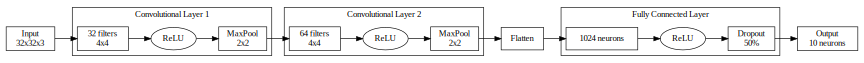

In [249]:
from graphviz import Digraph
from IPython.display import display

def create_nn_diagram():
    dot = Digraph(comment='CNN Architecture')
    dot.attr(rankdir='LR', size='12,8')  # Changed to LR for horizontal layout

    # Input Layer
    dot.node('input', 'Input\n32x32x3', shape='box')

    # Convolutional Layer 1
    with dot.subgraph(name='cluster_conv1') as c:
        c.attr(label='Convolutional Layer 1')
        c.node('conv1', '32 filters\n4x4', shape='box')
        c.node('relu1', 'ReLU', shape='ellipse')
        c.node('pool1', 'MaxPool\n2x2', shape='box')

    # Convolutional Layer 2
    with dot.subgraph(name='cluster_conv2') as c:
        c.attr(label='Convolutional Layer 2')
        c.node('conv2', '64 filters\n4x4', shape='box')
        c.node('relu2', 'ReLU', shape='ellipse')
        c.node('pool2', 'MaxPool\n2x2', shape='box')

    # Flatten
    dot.node('flatten', 'Flatten', shape='box')

    # Fully Connected Layer
    with dot.subgraph(name='cluster_fc') as c:
        c.attr(label='Fully Connected Layer')
        c.node('fc', '1024 neurons', shape='box')
        c.node('relu3', 'ReLU', shape='ellipse')
        c.node('dropout', 'Dropout\n50%', shape='box')

    # Output Layer
    dot.node('output', 'Output\n10 neurons', shape='box')

    # Connections
    dot.edge('input', 'conv1')
    dot.edge('conv1', 'relu1')
    dot.edge('relu1', 'pool1')
    dot.edge('pool1', 'conv2')
    dot.edge('conv2', 'relu2')
    dot.edge('relu2', 'pool2')
    dot.edge('pool2', 'flatten')
    dot.edge('flatten', 'fc')
    dot.edge('fc', 'relu3')
    dot.edge('relu3', 'dropout')
    dot.edge('dropout', 'output')

    # Display the diagram in the notebook
    display(dot)

create_nn_diagram()

# PHASE II: Train and Test CNN Model on CIFAR-10 Dataset

## ...

In [250]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=y_pred))

optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train = optimizer.minimize(cross_entropy)

init = tf.global_variables_initializer()

In [258]:
steps = 5000
batch_size = 100

In [256]:
# Lists to store accuracy, loss, and step number
accuracies = []
losses = []
step_numbers = []

In [259]:
with tf.Session() as sess:
    sess.run(init)
    
    for i in range(steps):
        batch_x, batch_y = ch.next_batch(batch_size)
        _, batch_loss = sess.run([train, cross_entropy], feed_dict={x: batch_x, y_true: batch_y, hold_prob: 0.5})
        
        # Collect accuracy and loss data every 100 steps
        if i % 100 == 0:
            print('Currently on step {}'.format(i))
            
            # Test the Model
            matches = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y_true, 1))
            acc = tf.reduce_mean(tf.cast(matches, tf.float32))
            
            test_accuracy = sess.run(acc, feed_dict={x: ch.test_images, y_true: ch.test_labels, hold_prob: 1.0})
            test_loss = sess.run(cross_entropy, feed_dict={x: ch.test_images, y_true: ch.test_labels, hold_prob: 1.0})
            
            print('Accuracy: {:.4f}'.format(test_accuracy))
            print('Loss: {:.4f}'.format(test_loss))
            print('\n')
            
            # Store accuracy, loss, and step number
            accuracies.append(test_accuracy)
            losses.append(test_loss)
            step_numbers.append(i)
# %%

Currently on step 0
Accuracy: 0.1000
Loss: 20.4260


Currently on step 100
Accuracy: 0.3827
Loss: 1.7382


Currently on step 200
Accuracy: 0.4291
Loss: 1.6221


Currently on step 300
Accuracy: 0.4946
Loss: 1.4077


Currently on step 400
Accuracy: 0.5188
Loss: 1.3421


Currently on step 500
Accuracy: 0.5338
Loss: 1.2829


Currently on step 600
Accuracy: 0.5592
Loss: 1.2292


Currently on step 700
Accuracy: 0.5809
Loss: 1.1751


Currently on step 800
Accuracy: 0.5832
Loss: 1.1780


Currently on step 900
Accuracy: 0.5916
Loss: 1.1498


Currently on step 1000
Accuracy: 0.6091
Loss: 1.1003


Currently on step 1100
Accuracy: 0.6170
Loss: 1.0938


Currently on step 1200
Accuracy: 0.6280
Loss: 1.0620


Currently on step 1300
Accuracy: 0.6237
Loss: 1.0621


Currently on step 1400
Accuracy: 0.6325
Loss: 1.0307


Currently on step 1500
Accuracy: 0.6434
Loss: 1.0106


Currently on step 1600
Accuracy: 0.6386
Loss: 1.0305


Currently on step 1700
Accuracy: 0.6595
Loss: 0.9780


Currently on step 180

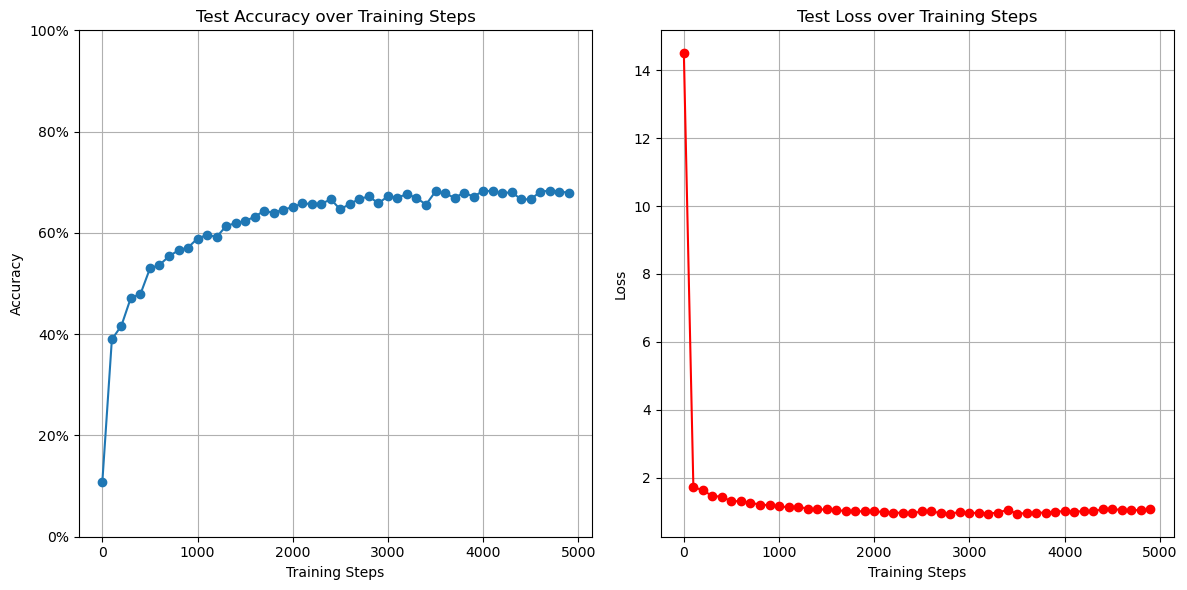

In [254]:
# After training, plot the accuracy and loss
plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(step_numbers, accuracies, marker='o')
plt.title('Test Accuracy over Training Steps')
plt.xlabel('Training Steps')
plt.ylabel('Accuracy')
plt.grid(True)
plt.ylim(0, 1)  # Assuming accuracy is between 0 and 1
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(step_numbers, losses, marker='o', color='r')
plt.title('Test Loss over Training Steps')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.grid(True)

plt.tight_layout()
plt.show()